In [1]:
#up 
import pandas as pd              # Package for working with tables
import numpy as np               # Package for working with vectors and matrices
import matplotlib.pyplot as plt  # Package for plotting
import seaborn as sns            # Another package for graphics
import plotly.graph_objs as go
# import chart_studio.plotly as py
import warnings
import sqlite3                   # Package for working with SQL data base 
import pickle                    # Package for loading data in a Python-specific format
import os                        # Package for working with the operating system
import chart_studio
from openTSNE import TSNE
from plotly.offline import iplot
from wordcloud import WordCloud  # Package for building word clouds
from tqdm import tqdm_notebook
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cosine
plt.style.use('ggplot')          # we set a beautiful style for matplotlib graphs
%matplotlib inline
warnings.filterwarnings("ignore")
chart_studio.tools.set_credentials_file(username='elper.ilya', api_key='vNuUxjAopA7orkltFk9K')


In [2]:
conn = sqlite3.connect('2012_to_2017_deputat_speakers.db')
query = "SELECT * FROM df_for_modeling"  
filtered_rows = pd.read_sql(query, conn)
conn.close()
directory = 'lda_models'
with open(os.path.join(directory, 'ldamodel_30'),'rb')as f:
    ldamodel_30=pickle.load(f)

with open(os.path.join(directory, 'corpus'),'rb')as f:
    corpus=pickle.load(f)
with open('lda_models/lda_30_topics', 'rb') as f:
    lda_30_topics = pickle.load(f)

expElogbeta=np.load(os.path.join(directory, 'ldamodel_30.expElogbeta.npy'))
ldamodel_30.expElogbeta = expElogbeta



In [3]:
def plotWordCloud(topic_number):
    """
       Builds word visualization based on topic texts
    """
    # we get the frequencies and words of the topic
    
    text = dict(lda_30_topics[topic_number][1])
    
    # building a word cloud
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("theme nimber {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");




def topicProfileGenre(model, party, dataset, corpus, genre='party'):

    # We will store the result here
    theme_results = [ ]

    # What is the number of topics in the model?
    r = model.num_topics
    
    # We select from the table those rows that correspond to partii
    if genre=='party':
        num = dataset[dataset.party == party].index.values
    elif genre=='speaker':
        num = dataset[dataset.speaker_name == party].index.values
    elif genre=='country':
        num = dataset[dataset.country_of_birth == party].index.values

    # Vector for genre theme profile
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Let's go through all the political parties
    for i in num:
        try:
            # pull out the thematic profile of the current deputy
            cur_user_prof = model.get_document_topics(corpus[i])

            # sort by topic numbers
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # make a vector with topic numbers
            prob = np.array([cup[1] for cup in cur_user_prof]) # make a vector with weights  
            theme_profile[ind] += prob        # We increase the corresponding weights
        except:
            err += 1 # If an error occurs, it means the profile is broken

    # Normalize to unity
    if err !=0:
        print('Proportion of broken profiles for {}:'.format(party), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

def create_topic_names(lda_topics):
    topic_names = {}
    for topic_id, topic_words in lda_topics:
        topic_name = ' '.join(word for word, _ in topic_words[:5])  
        topic_names[topic_id] = topic_name
    return topic_names

# Creating Topic Titles
themes_30 = create_topic_names(lda_30_topics)

def profilePlot(theme_profile, party, themes=themes_30):
    """
    Builds a thematic profile for each party
     theme_profile:
         thematic profile, dict
     party:
         government party
     themes dict:
         topic names
     """
    
    theme_profile = theme_profile[party]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # draw a picture
    sns.set(font_scale=1)
    plt.subplots(figsize=(20, 10))
    
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Thematic profile for {}: \n'.format(party))
    ax.set_ylim(0.6, 0) 
    plt.show()


# def get_interpretable_topics(topics, interpretation):
#     topics_clean = {}
    
#     for key, value in topics.items():
#         clean_topics = []
#         clean_probs = []
#         for topic, prob in value:
#             if themes_30[topic]!="":
#                 clean_topics.append(topic)
#                 clean_probs.append(prob)

#         clean_probs = np.array(clean_probs)/np.sum(clean_probs)

#         topics_clean[key] = list(zip(clean_topics, clean_probs))
        
#     return topics_clean



In [4]:
from ipywidgets import interact  

@interact(var=list(range(0, 30)))
def plot(var):
    _ =  plotWordCloud(topic_number=var)

interactive(children=(Dropdown(description='var', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [5]:
party_themes = { }
for party in tqdm_notebook(filtered_rows.party.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_30, party, filtered_rows, corpus)
    
    # Записываем их в словарик:
    party_themes[party] = theme

  0%|          | 0/18 [00:00<?, ?it/s]

In [6]:
speaker_themes = { }
for speaker in tqdm_notebook(filtered_rows.speaker_name.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_30, speaker, filtered_rows, corpus, genre='speaker')
    
    # Записываем их в словарик:
    speaker_themes[speaker] = theme

  0%|          | 0/290 [00:00<?, ?it/s]

In [7]:
country_themes = { }
for country in tqdm_notebook(filtered_rows.country_of_birth.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_30, country, filtered_rows, corpus, genre='country')
    
    # Записываем их в словарик:
    country_themes[country] = theme

  0%|          | 0/18 [00:00<?, ?it/s]

In [8]:
# Сохраняем словарик с тематическими профилями 
with open('party_themes_30', 'wb') as f:
    pickle.dump(party_themes, f)

with open('country_themes_30', 'wb') as f:
    pickle.dump(country_themes, f)

with open('speaker_themes_30', 'wb') as f:
    pickle.dump(speaker_themes, f)

In [9]:
# Читаем словарик с тематическими профилями 
# with open('party_themes_30', 'rb') as f:
#     party_themes = pickle.load(f)
    
# with open('country_themes_30', 'rb') as f:
#     country_themes = pickle.load(f)

# with open('speaker_themes_30', 'rb') as f:
#     speaker_themes = pickle.load(f)

In [10]:
@interact(party=filtered_rows['party'].unique())
def plot(party):
    _ =  profilePlot(party_themes, party)

interactive(children=(Dropdown(description='party', options=('Regering', 'Groenlinks', 'Pvda', 'Vvd', 'Sgp', '…

In [11]:
@interact(country=filtered_rows['country_of_birth'].unique())
def plot(country):
    _ =  profilePlot(country_themes, country)

interactive(children=(Dropdown(description='country', options=('The Netherlands', 'Afghanistan', 'Czechia', 'M…

In [12]:
@interact(speaker=filtered_rows['speaker_name'].unique())
def plot(speaker):
    country = filtered_rows.loc[filtered_rows['speaker_name'] == speaker, 'country_of_birth'].iloc[0]
    print(f"{speaker} was born in {country}")
    _ =  profilePlot(speaker_themes, speaker)

interactive(children=(Dropdown(description='speaker', options=('Jan Kees De Jager', 'Ineke Van Gent', 'Sharon …

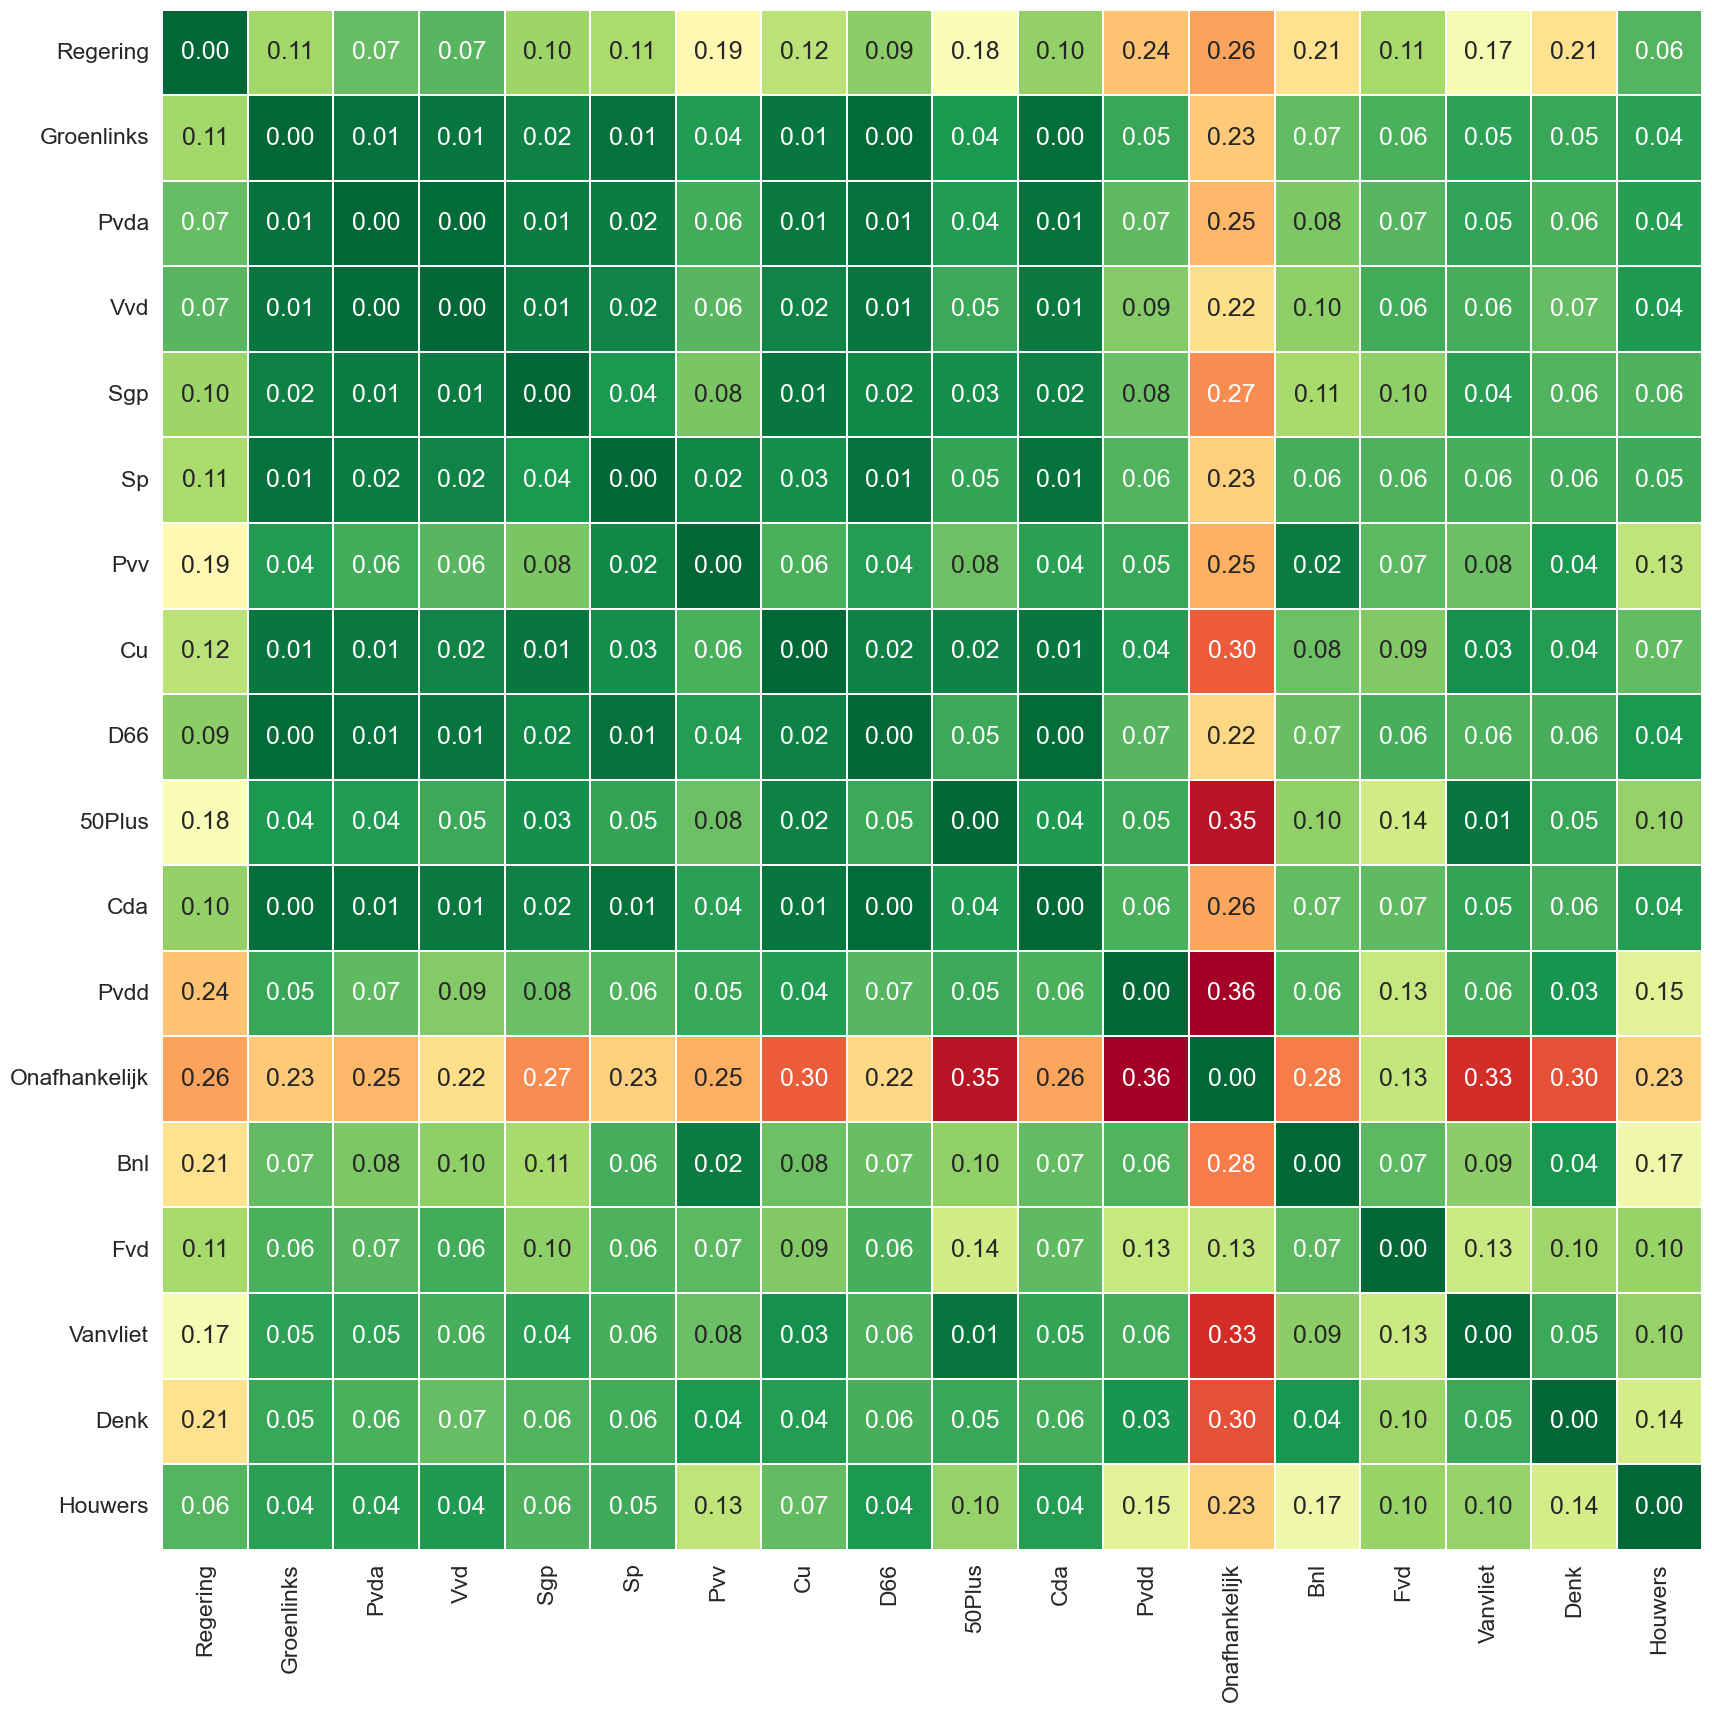

In [13]:
from scipy.spatial.distance import cosine
partys = list(party_themes.keys())
n = len(partys)  # выясняем число жанров
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in party_themes[partys[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in party_themes[partys[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние
            
sns.set(font_scale=1.5)
plt.subplots(figsize=(20, 20))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=partys, xticklabels=partys,cbar=False);

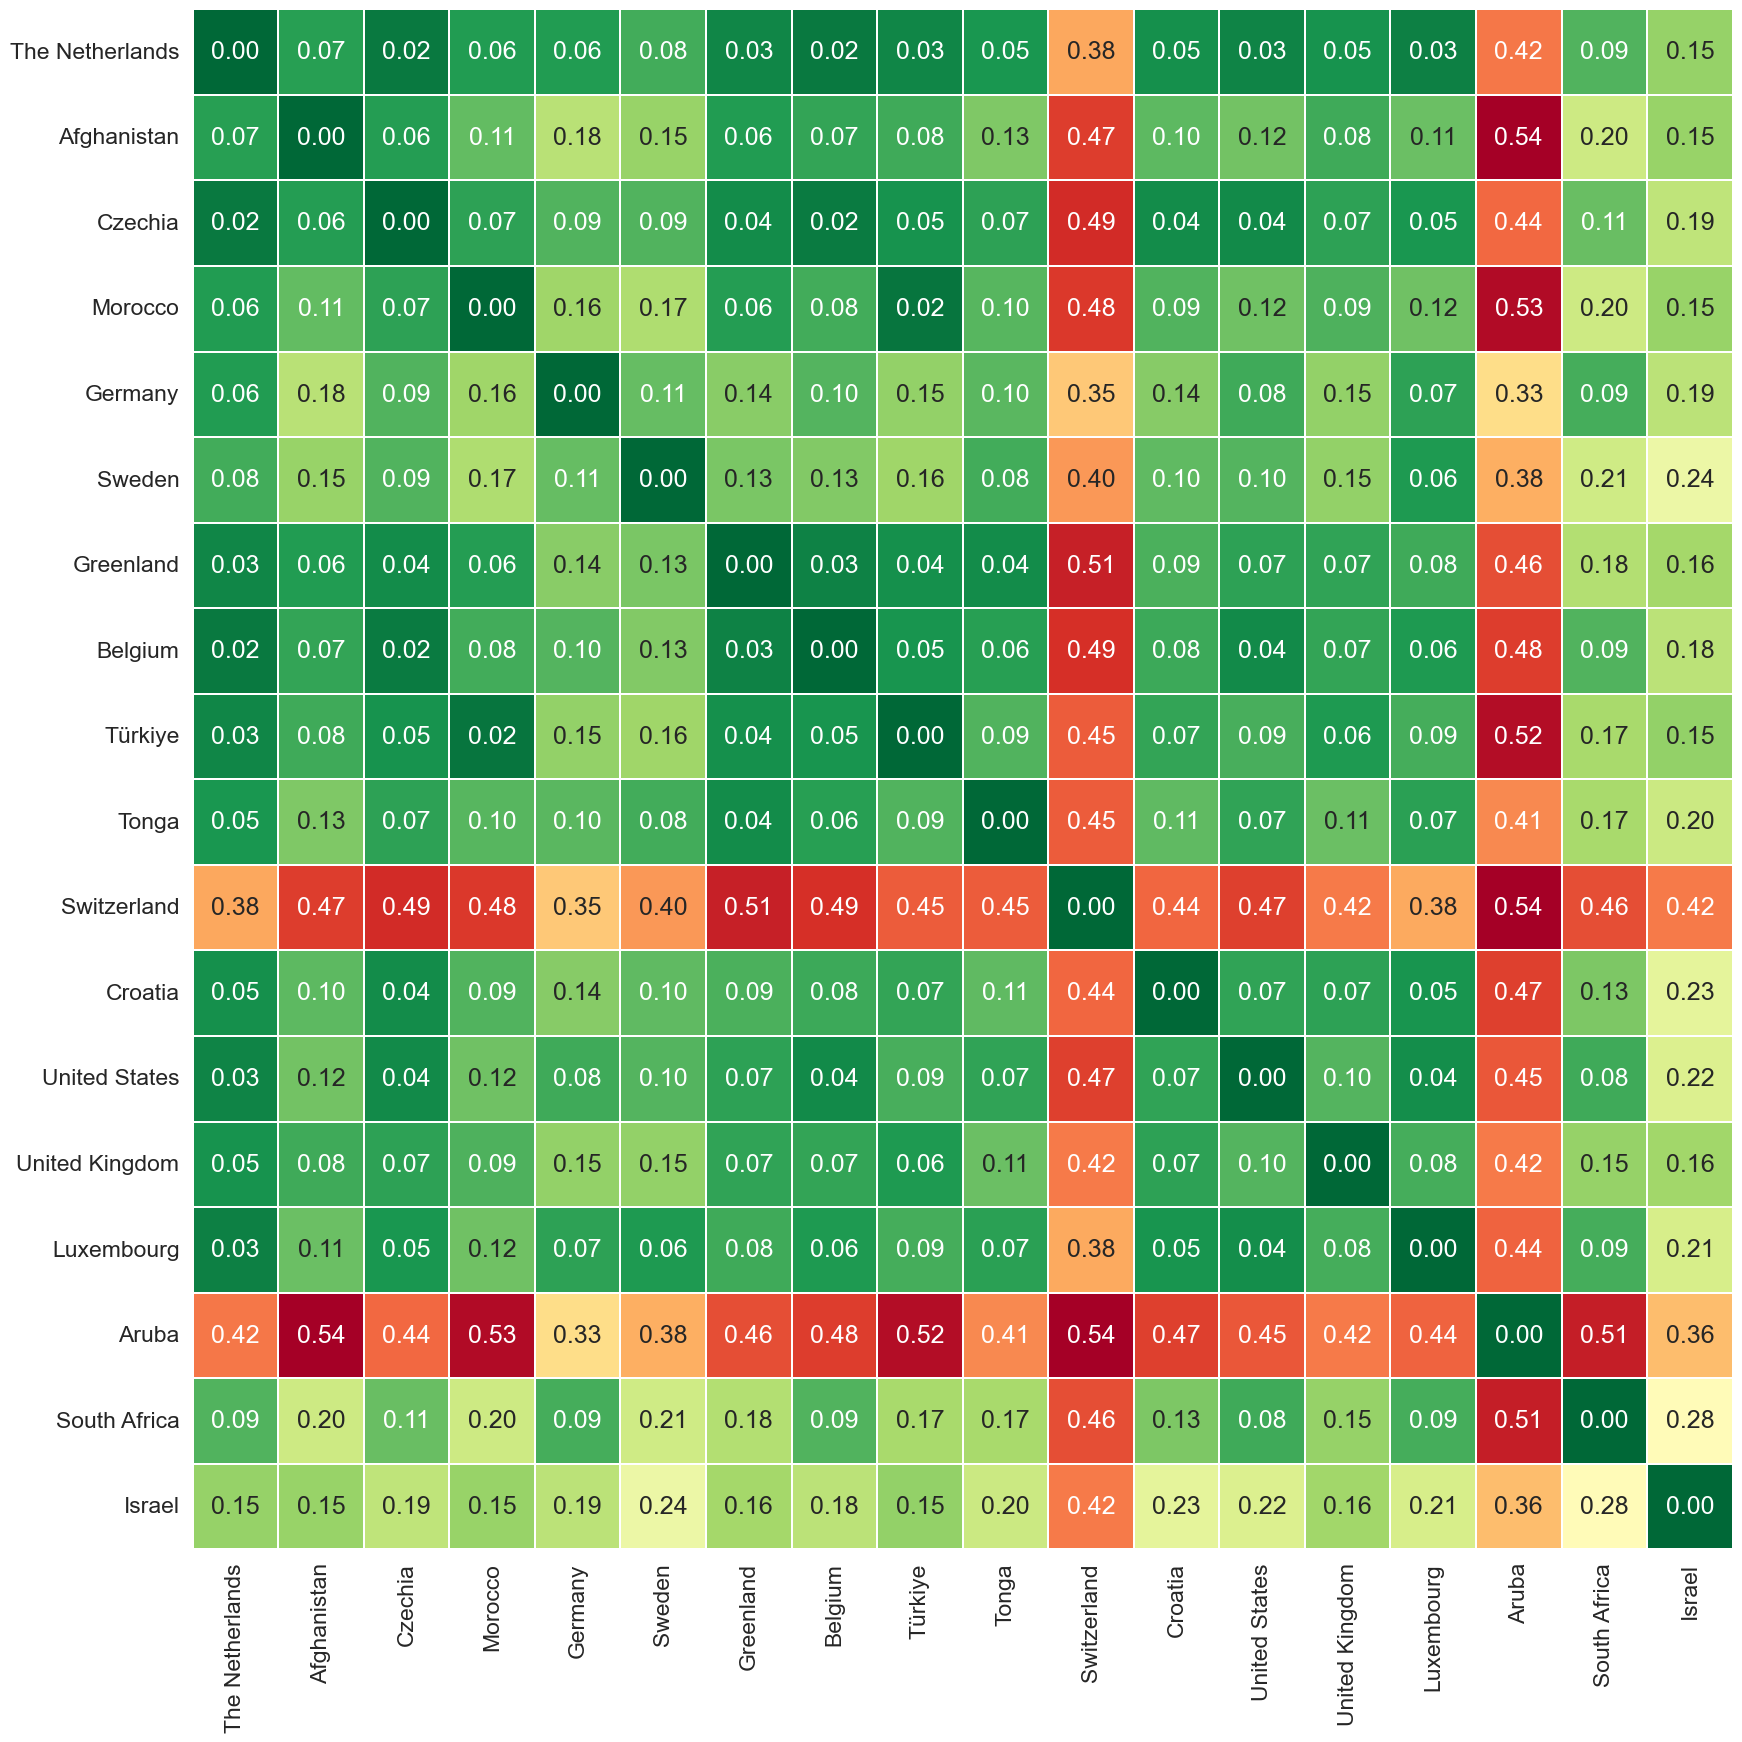

In [14]:

countrys = list(country_themes.keys())
n = len(countrys)  # выясняем число жанров
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in country_themes[countrys[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in country_themes[countrys[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние
            
sns.set(font_scale=1.5)
plt.subplots(figsize=(20, 20))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=countrys, xticklabels=countrys,cbar=False);

In [15]:
speakers = list(speaker_themes.keys())
n = len(speakers)  # выясняем число жанров
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in speaker_themes[speakers[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in speaker_themes[speakers[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние
            
speakers_distances = pd.DataFrame(R, columns=speakers, index=speakers)

In [16]:
def plotMostSimilarDifferent(speaker, distances=speakers_distances):
    """
        Строит график с самыми похожими и непохожими по косинусной мере исполнителями
    """
    slice_most_similar = distances.nsmallest(
        11, [speaker])[[speaker]].iloc[1:]
    slice_most_different = distances.nlargest(
        10, [speaker])[[speaker]].sort_values(by=speaker)
    
    result = pd.concat([slice_most_similar, slice_most_different])
    
    plt.figure(figsize=(20, 30))
    ax = plt.axes() 
    sns.heatmap(result.values.reshape(1, 20), ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                     cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=result.index)
    ax.set_title('{}: топ-10 похожих и непохожих\n'.format(speaker).capitalize())
    plt.show()

In [17]:
@interact(speaker=filtered_rows['speaker_name'].unique())
def plot(speaker):
    country = filtered_rows.loc[filtered_rows['speaker_name'] == speaker, 'country_of_birth'].iloc[0]
    print(f"{speaker} was born in {country}")
    _ =  plotMostSimilarDifferent(speaker)

interactive(children=(Dropdown(description='speaker', options=('Jan Kees De Jager', 'Ineke Van Gent', 'Sharon …

## t-SNE

In [18]:
partys_themes_clusters = {}
for k, v in party_themes.items():
    partys_themes_clusters[k] = [prob[1] for prob in v]
    
partys_themes_clusters = pd.DataFrame(partys_themes_clusters).T

In [19]:

# Создание экземпляра TSNE
tsne = TSNE(n_jobs=4)  # Установите n_jobs на количество доступных ядер вашего процессора

# Выполнение t-SNE преобразования
tsne_features = tsne.fit(np.array(partys_themes_clusters))

# Создание объекта Scatter для визуализации
trace = go.Scatter(
    x = tsne_features[:, 0],
    y = tsne_features[:, 1],
    mode = 'markers+text',
    text = partys_themes_clusters.index,
    textposition='top center'
)

# Собираем данные и макет для построения
data = [trace]
layout = go.Layout(
    autosize=False,
    width=700,
    height=700
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='size-margins')

Perplexity value 30 is too high. Using perplexity 5.67 instead


In [20]:
country_themes_clusters = {}
for k, v in country_themes.items():
    country_themes_clusters[k] = [prob[1] for prob in v]
    
country_themes_clusters = pd.DataFrame(country_themes_clusters).T

# Создание экземпляра TSNE
tsne = TSNE(n_jobs=4)  # Установите n_jobs на количество доступных ядер вашего процессора

# Выполнение t-SNE преобразования
tsne_features = tsne.fit(np.array(country_themes_clusters))

# Создание объекта Scatter для визуализации
trace = go.Scatter(
    x = tsne_features[:, 0],
    y = tsne_features[:, 1],
    mode = 'markers+text',
    text = country_themes_clusters.index,
    textposition='top center'
)

# Собираем данные и макет для построения
data = [trace]
layout = go.Layout(
    autosize=False,
    width=700,
    height=700
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='size-margins')


Perplexity value 30 is too high. Using perplexity 5.67 instead


In [21]:
speaker_themes_clusters = {}
for k, v in speaker_themes.items():
    speaker_themes_clusters[k] = [prob[1] for prob in v]
    
speaker_themes_clusters = pd.DataFrame(speaker_themes_clusters).T
# Создание экземпляра TSNE
tsne = TSNE(n_jobs=10)  

# Выполнение t-SNE преобразования
tsne_features = tsne.fit(np.array(speaker_themes_clusters))

# Создание словаря для сопоставления страны рождения и цвета
country_color_mapping = {
    'The Netherlands': 'rgb(31, 119, 180)',
    'Afghanistan': 'rgb(255, 127, 14)',
    'Czechia': 'rgb(44, 160, 44)',
    'Morocco': 'rgb(214, 39, 40)',
    'Germany': 'rgb(148, 103, 189)',
    'Sweden': 'rgb(140, 86, 75)',
    'Greenland': 'rgb(227, 119, 194)',
    'Belgium': 'rgb(127, 127, 127)',
    'Türkiye': 'rgb(188, 189, 34)',
    'Tonga': 'rgb(23, 190, 207)',
    'Switzerland': 'rgb(152, 223, 138)',
    'Croatia': 'rgb(255, 187, 120)',
    'United States': 'rgb(255, 0, 0)',
    'United Kingdom': 'rgb(255, 0, 255)',
    'Luxembourg': 'rgb(189, 189, 189)',
    'Aruba': 'rgb(217, 217, 217)',
    'South Africa': 'rgb(0, 255, 255)',
    'Israel': 'rgb(155, 155, 155)'
}

# speaker_color_mapping={speakers:filtered_rows.loc[filtered_rows['speaker_name'] == speaker, 'country_of_birth'].iloc[0].map.country_color_mapping}
speaker_color_mapping = {}

for speaker in speakers:
    country = filtered_rows.loc[filtered_rows['speaker_name'] == speaker, 'country_of_birth'].iloc[0]
    color = country_color_mapping.get(country, 'default_color')  # Use 'default_color' if country not found
    speaker_color_mapping[speaker] = color

# Получение цвета для каждой страны из списка стран
# colors = [country_color_mapping[country] for country in country_themes.keys()]
colors = [speaker_color_mapping[speaker] for speaker in speaker_themes_clusters.index]

# Создание объекта Scatter для визуализации
trace = go.Scatter(
    x=tsne_features[:, 0],
    y=tsne_features[:, 1],
    mode='markers+text',
    text=speaker_themes_clusters.index,
    textfont=dict(size=7),
    textposition='top center',
    marker=dict(color=colors, size=5)
)

# Собираем данные и макет для построения
# data = [trace]
# layout = go.Layout(
#     autosize=False,
#     width=1000,
#     height=1000
# )
# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='size-margins')
# Создание объектов Scatter для легенды
legend_traces = []
for country, color in country_color_mapping.items():
    legend_traces.append(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        name=country
    ))

# Собираем данные и макет для построения
data = [trace] + legend_traces
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    showlegend=True
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='size-margins')

In [22]:
# kmeanModel = KMeans(n_clusters=len(country_of_birth_themes_clean.keys())).fit(tsne_features)
# # Создание экземпляра TSNE
# tsne = TSNE(n_jobs=10)  # Установите n_jobs на количество доступных ядер вашего процессора

# # Выполнение t-SNE преобразования
# tsne_features = tsne.fit(np.array(speaker_themes_clusters))
# # Create a trace
# trace = go.Scatter(
#     x = tsne_features[:, 0],
#     y = tsne_features[:, 1],
#     mode = 'markers+text',
#     text = speaker_themes_clusters.index,
#     textfont=dict(
#         size=7,
#     ),
#     textposition='top center',
#     marker = dict(
#         color=kmeanModel.predict(tsne_features),
#         size = 4,
#         colorscale='Jet'
#     )
# )

# data = [trace]

# layout = go.Layout(
#     autosize=False,
#     width=1000,
#     height=1000,
#     xaxis=dict(
#         autorange=True,
#         showgrid=False,
#         zeroline=False,
#         showline=False,
#         ticks='',
#         showticklabels=False
#     ),
#     yaxis=dict(
#         autorange=True,
#         showgrid=False,
#         zeroline=False,
#         showline=False,
#         ticks='',
#         showticklabels=False
#     ),
#     plot_bgcolor='rgb(255, 255, 255)',  # белый цвет фона графика
#     paper_bgcolor='rgb(255, 255, 255)'  # белый цвет фона листа
# )

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='performers t-SNE')